In [9]:
import sys
sys.path.append('../classes')

In [10]:
from DataLoader import DataLoaderFactory
import os

data_dir = "../../data/quickdraw_subset_np"

input_file_name = "train_images.npy"
label_file_name = "train_labels.npy"

inputs_path = os.path.join(data_dir, input_file_name)
labels_path = os.path.join(data_dir, label_file_name)

train_loader, val_loader = DataLoaderFactory.build(
    inputs_path, labels_path, val_ratio=0.1
)

In [12]:
import torch

class CNNEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 14x14
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 7x7
            torch.nn.ReLU(),
        )
        self.fc = torch.nn.Linear(32 * 7 * 7, 64)  # latent space

    def forward(self, x):
        x = self.encoder(x)
        return self.fc(x.view(x.size(0), -1))

class CNNDecoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Linear(64, 32 * 7 * 7)
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1, padding=1),  # 14x14
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 1, 3, stride=2, output_padding=1, padding=1),   # 28x28
            torch.nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 32, 7, 7)
        return self.decoder(x)


In [28]:
losses = {}

encoder = CNNEncoder()
decoder = CNNDecoder()

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)

for step in range(1000):
    x, _ = train_loader.get_batch(256)
    x = torch.from_numpy(x).unsqueeze(1)
    x = x / 255.0

    

    z = encoder(x)
    x_hat = decoder(z)
    loss = torch.nn.functional.mse_loss(x_hat, x)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses[step] = loss.item()
    if step % 5 == 0:
        print(f"Step {step}")
        print(f"Loss: {loss.item()}")

Step 0
Loss: 0.24782823026180267
Step 5
Loss: 0.24227388203144073
Step 10
Loss: 0.21222928166389465
Step 15
Loss: 0.14531610906124115
Step 20
Loss: 0.11991545557975769
Step 25
Loss: 0.11243095248937607
Step 30
Loss: 0.1061517596244812
Step 35
Loss: 0.1036272644996643
Step 40
Loss: 0.09914614260196686
Step 45
Loss: 0.09777773916721344
Step 50
Loss: 0.09737170487642288
Step 55
Loss: 0.0942504033446312
Step 60
Loss: 0.09398141503334045
Step 65
Loss: 0.09464801102876663
Step 70
Loss: 0.09412790089845657
Step 75
Loss: 0.09232433140277863
Step 80
Loss: 0.09216499328613281
Step 85
Loss: 0.09208021312952042
Step 90
Loss: 0.09231144189834595
Step 95
Loss: 0.0923285260796547
Step 100
Loss: 0.09007870405912399
Step 105
Loss: 0.09065128117799759
Step 110
Loss: 0.08972854912281036
Step 115
Loss: 0.09000171720981598
Step 120
Loss: 0.08905235677957535
Step 125
Loss: 0.08620504289865494
Step 130
Loss: 0.08662865310907364
Step 135
Loss: 0.08334702253341675
Step 140
Loss: 0.0825202539563179
Step 145
Los

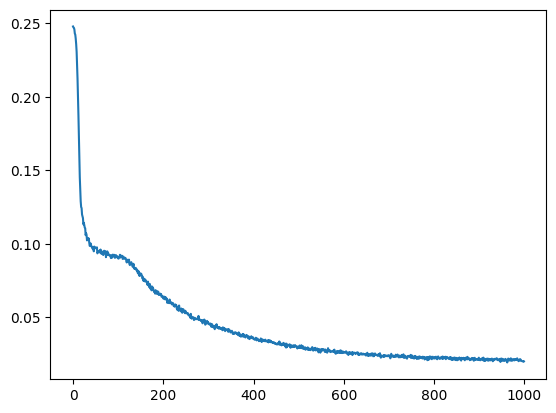

In [29]:
# Plot loss

import matplotlib.pyplot as plt

plt.plot(list(losses.keys()), list(losses.values()))

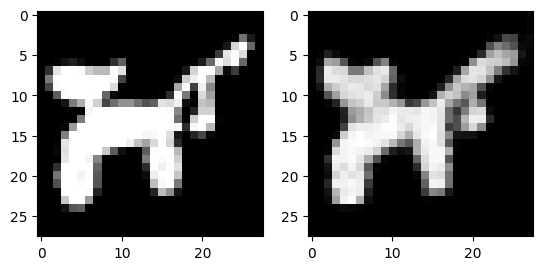

In [58]:
use = "trained"

untrained_encoder = CNNEncoder()
untrained_decoder = CNNDecoder()

x, _ = train_loader.get_batch(1)
x = torch.from_numpy(x).unsqueeze(1)
x = x / 255.0

if use == "trained":
    z = encoder(x)
    x_hat = decoder(z)
else:
    z = untrained_encoder(x)
    x_hat = untrained_decoder(z)

plt.subplot(1, 2, 1)
plt.imshow(x[0, 0].detach().numpy(), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(x_hat[0, 0].detach().numpy(), cmap='gray')
plt.show()

